In [25]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [26]:


import importlib
import functions
import spectrogram_plotting_functions

importlib.reload(functions)
importlib.reload(spectrogram_plotting_functions)

<module 'spectrogram_plotting_functions' from 'c:\\Users\\Thomas\\Desktop\\cpl_analysis_naman\\spectrogram_plotting_functions.py'>

## 02 Loading the folder that contains our data

In [27]:
import glob
import getpass
user= (getpass.getuser())
print("Hello", user)

base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat_filtered\\*.mat')
savepath = base+'\\results\\'
print(files)

Hello Thomas
['C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk1_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk3_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk5_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk6_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat_filtered\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat_filtered\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat_filtered\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat_filtered\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat_filtered\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat_filtered\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat_filtered\\20230610_dk

In [28]:
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}

In [29]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

events_codes_all = {}
averaged_data=pd.DataFrame(columns=['mouse_id','task','channel_id','average_power_spectrum'])

for file in files:
    #if 'dk6' in file:
        print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, mouse_id, task = functions.exp_params(base_name)
        print(date, mouse_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        print(date, mouse_id, task)

        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)

        if 'Keyboard' in channels:
            events = f['Keyboard']
        elif 'keyboard' in channels:
            events = f['keyboard']
        elif 'memory' in channels:
            events = f['memory']
        elif 'Memory' in channels:
            events = f['Memory']

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = functions.generate_epochs_with_first_event(events_codes, events_times)

        first_event = events_times[0]
        for channeli in channels:
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                print(raw_data.shape, raw_time.shape, sampling_rate)
                normalized_data, time, data_before = functions.data_normalization(raw_data, raw_time, first_event, sampling_rate)

                notch_filtered_data = functions.iir_notch(normalized_data, sampling_rate, 60)
                total = notch_filtered_data
                compiled_data = []
                power_spectra = []

                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_complete_trial = functions.extract_complete_trial_data(total, time, door_timestamp, dig_timestamp, sampling_rate)
                    faxis, Sxx = functions.frequency_domain(data_complete_trial, time)
                    compiled_data.append([i, faxis, Sxx])
                    power_spectra.append(Sxx)

                compiled_data_df = pd.DataFrame(compiled_data, columns=['Trial', 'Frequency Axis', 'Power Spectrum'])
                print(compiled_data_df.shape)

                # Ensure all power spectra have the same length
                min_length = min(len(spectrum) for spectrum in power_spectra)
                power_spectra = [spectrum[:min_length] for spectrum in power_spectra]

                # Calculate the average power spectrum
                power_spectra = np.array(power_spectra)
                average_power_spectrum = np.mean(power_spectra, axis=0)
                row=pd.DataFrame({
                    'mouse_id':mouse_id,
                    'task':task,
                    'channel_id':channel_id,
                    'average_power_spectrum':[average_power_spectrum]
                })
                averaged_data=pd.concat([averaged_data,row])

C:\Users\Thomas\Dropbox\CPLab\all_data_mat_filtered\20230529_dk1_nocontext.mat
20230529 dk1 nocontext
20230529 dk1 nocontext
['Keyboard', 'LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']
(1516022,) (1516022,) 2000
normalizing data
notch filter applied
49.0
181.20385499999998 120.0 182.713855 49.0
48.0
237.771855 120.0 239.46185499999999 48.0
49.0
279.551855 120.0 280.29184999999995 49.0
48.0
348.953855 120.0 349.84385 48.0
49.0
466.78984999999994 120.0 468.25985499999996 49.0
49.0
526.9038549999999 120.0 528.223855 49.0
49.0
570.771855 120.0 571.4418549999999 49.0
48.0
617.237855 120.0 618.4178549999999 48.0
49.0
669.49786 120.0 670.737855 49.0
49.0
705.3358549999999 120.0 706.5758549999999 49.0
(10, 3)
(1516022,) (1516022,) 2000
normalizing data
notch filter applied
49.0
181.20385499999998 120.0 182.713855 49.0
48.0
237.771855 120.0 239.46185499999999 48.0
49.0
279.551855 120.0 280.29184999999995 49.0
48.0
348.953855 120.0 349.84385 48

c:\Users\Thomas\anaconda3\envs\lfp_analysis\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Thomas\anaconda3\envs\lfp_analysis\lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Thomas\anaconda3\envs\lfp_analysis\lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Thomas\anaconda3\envs\lfp_analysis\lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Thomas\anaconda3\envs\lfp_analysis\lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


normalizing data
notch filter applied
49.0
18.434154999999997 120.0 20.91415 49.0
49.0
117.14415499999998 120.0 118.77414999999999 49.0
49.0
155.21214999999998 120.0 158.22215 49.0
49.0
194.490155 120.0 196.520155 49.0
49.0
242.50214999999997 120.0 244.27215499999997 49.0
49.0
286.59815499999996 120.0 287.78815499999996 49.0
49.0
323.07615999999996 120.0 324.76615999999996 49.0
(7, 3)
(757278,) (757278,) 2000
normalizing data
notch filter applied
49.0
18.434154999999997 120.0 20.91415 49.0
49.0
117.14415499999998 120.0 118.77414999999999 49.0
49.0
155.21214999999998 120.0 158.22215 49.0
49.0
194.490155 120.0 196.520155 49.0
49.0
242.50214999999997 120.0 244.27215499999997 49.0
49.0
286.59815499999996 120.0 287.78815499999996 49.0
49.0
323.07615999999996 120.0 324.76615999999996 49.0
(7, 3)
(757277,) (757277,) 2000
normalizing data
notch filter applied
49.0
18.434154999999997 120.0 20.91415 49.0
49.0
117.14415499999998 120.0 118.77414999999999 49.0
49.0
155.21214999999998 120.0 158.2221

Now we will plot averaged power spectrum in a single plot for each mouse

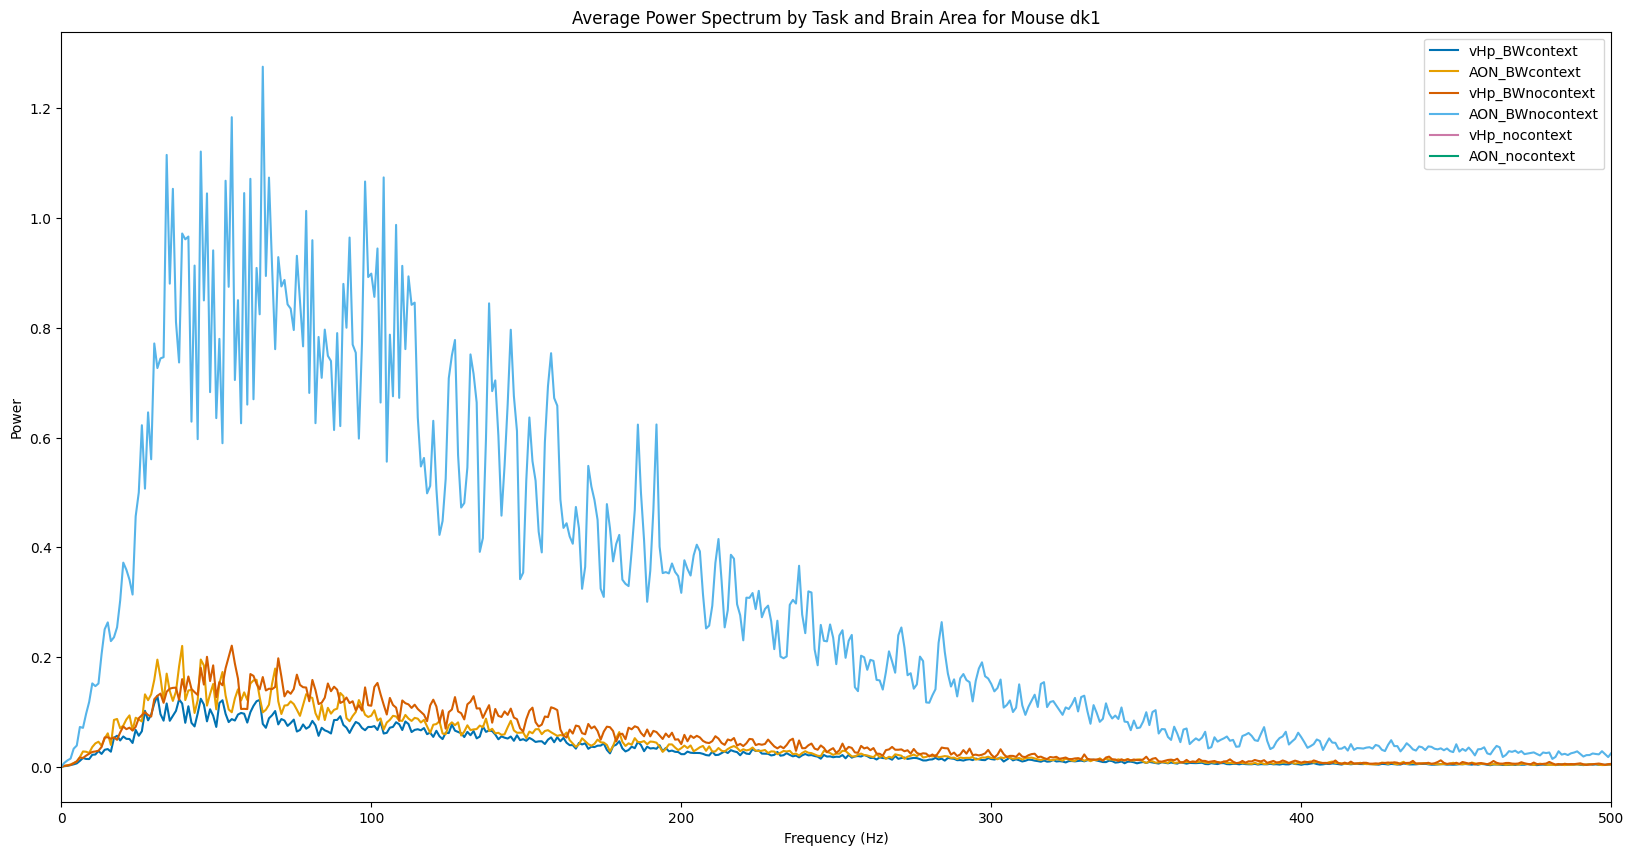

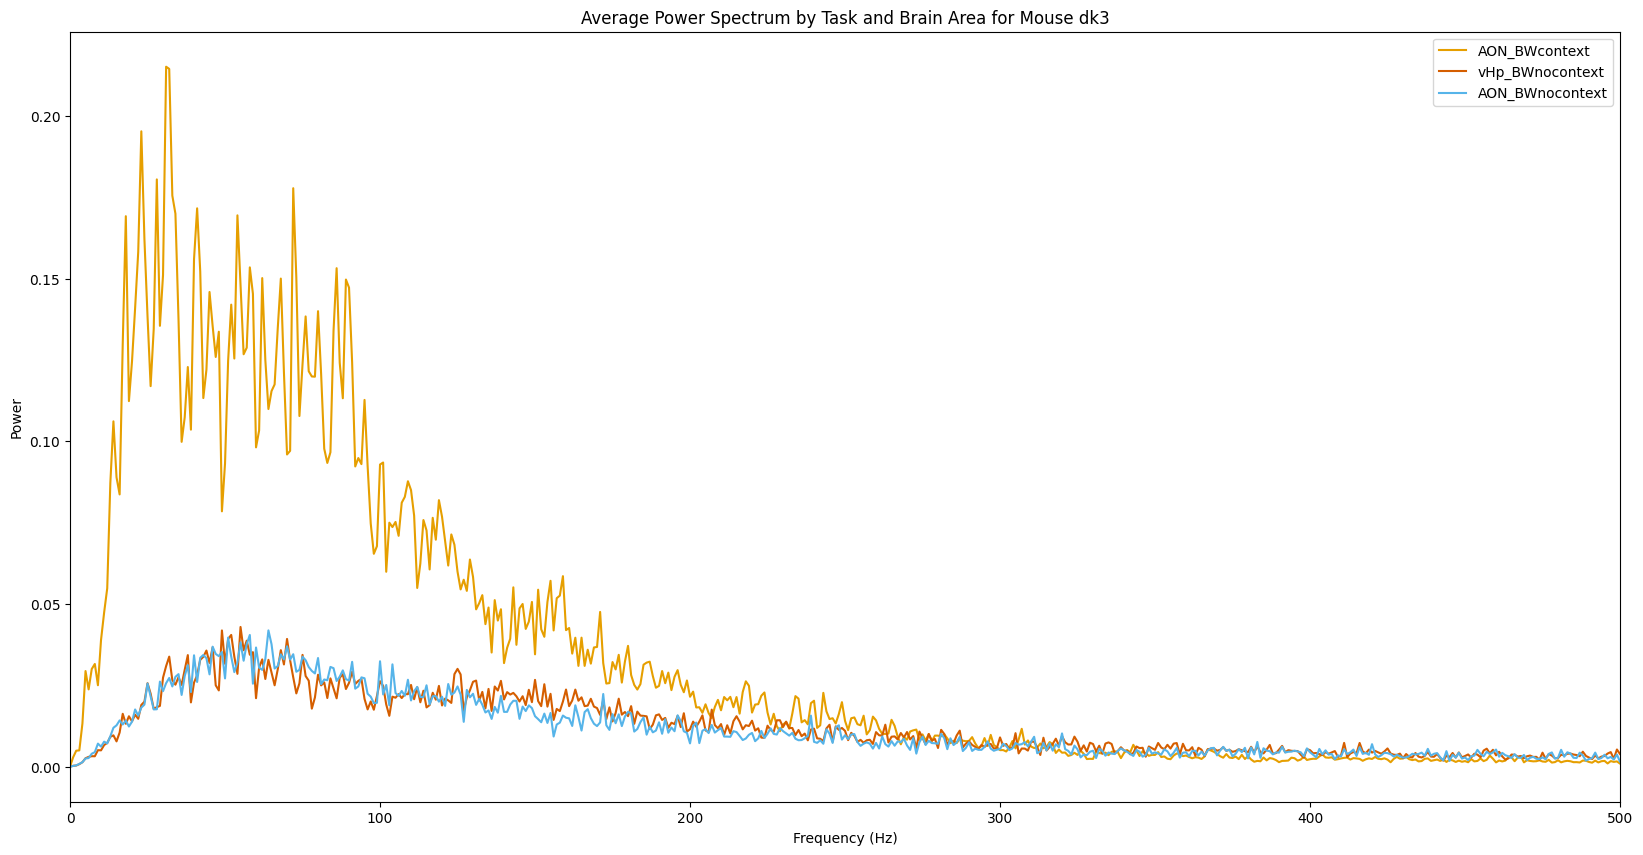

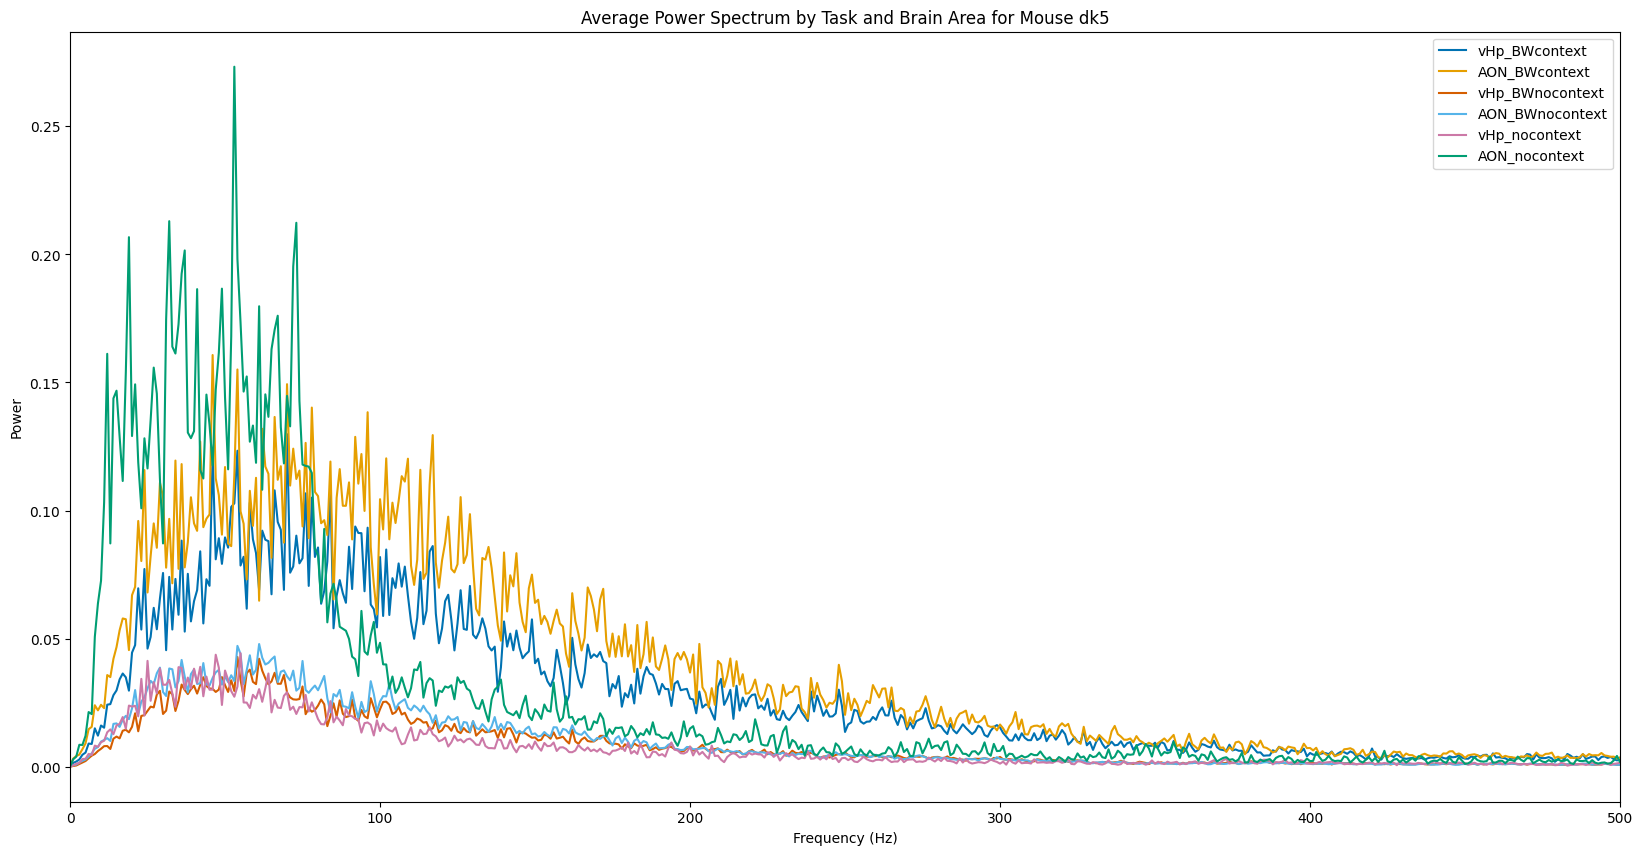

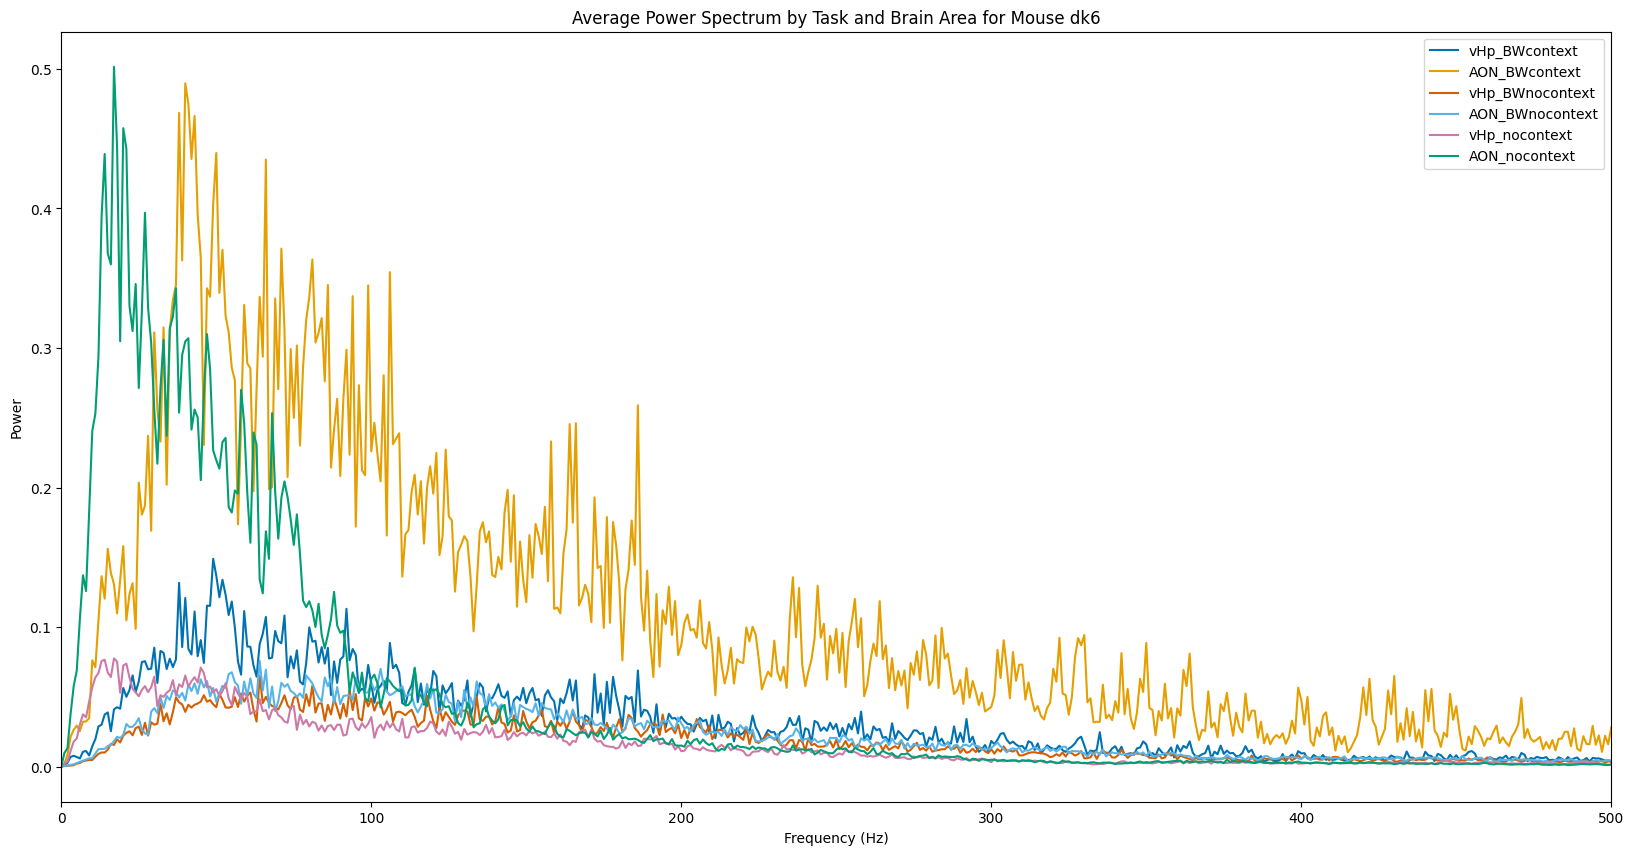

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}

brain_areas = ['AON', 'vHp']
mouse_ids = np.unique(averaged_data['mouse_id'])
tasks = np.unique(averaged_data['task'])

for mouse in mouse_ids:
    mouse_data = averaged_data[averaged_data['mouse_id'] == mouse]

    fig, ax = plt.subplots(figsize=(20, 10))

    for i, task in enumerate(tasks):
        task_data = mouse_data[mouse_data['task'] == task]
        task_data = task_data.reset_index(drop=True)
        task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
        task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
        task_data_vhp = task_data_vhp.reset_index(drop=True)
        task_data_aon = task_data_aon.reset_index(drop=True)

        color_aon = color_scheme['AON'][i % len(color_scheme['AON'])]
        color_vhp = color_scheme['vHp'][i % len(color_scheme['vHp'])]

        if not task_data_vhp.empty:
            # Ensure all power spectra have the same length
            min_length_vhp = min(len(spectrum) for spectrum in task_data_vhp['average_power_spectrum'])
            task_data_vhp_spectra = [spectrum[:min_length_vhp] for spectrum in task_data_vhp['average_power_spectrum']]
            task_data_vhp_mean = np.mean(task_data_vhp_spectra, axis=0)
            ax.plot(task_data_vhp_mean, label=f'vHp_{task}', color=color_vhp)

        if not task_data_aon.empty:
            # Ensure all power spectra have the same length
            min_length_aon = min(len(spectrum) for spectrum in task_data_aon['average_power_spectrum'])
            task_data_aon_spectra = [spectrum[:min_length_aon] for spectrum in task_data_aon['average_power_spectrum']]
            task_data_aon_mean = np.mean(task_data_aon_spectra, axis=0)
            ax.plot(task_data_aon_mean, label=f'AON_{task}', color=color_aon)

    ax.set_xlim(0, 500)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.set_title(f'Average Power Spectrum by Task and Brain Area for Mouse {mouse}')
    ax.legend()
    fig.savefig(os.path.join(savepath,f'average_power_spectrum_{mouse}.png'), dpi=300, bbox_inches='tight')
    plt.show()